In [8]:
#Import modules
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches, text, patheffects
import cv2
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import scipy.cluster.hierarchy as hcluster
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import scipy.stats
import ast

In [2]:
def group_DBSCAN(df):
    x = df[["c_x", "c_y"]].to_numpy()
    cluster = DBSCAN(eps=15, min_samples=5).fit(x)
    labels = cluster.labels_
    df["cluster_id"] = labels
    return labels
    #n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    #n_noise_ = list(labels).count(-1)
    
    #EVENTUALLY: run DBSCAN, or sort for running H-Cluster if DBSCAN gives a bad result
    #hcluster = []
    #comp = int(len(df)) / len(((df["labeler_id"].unique())))
    #decision = comp / int(n_clusters_)
    #if decision > 0.9:
    #    df["cluster_id"] = labels
    #    return labels
    #else:
    #    hcluster.append(df["filename"])
    #    return hcluster

In [ ]:
#Needs more work later-- will require different method to define labels
def group_Hcluster(df):
    data = df["centers"]
    thresh = 14
    hclusters = hcluster.fclusterdata(data, thresh, criterion="distance")


In [9]:
#JSON file with all DGC labels
path = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/coco/labelbox.csv"
with open(path) as f:
  df = pd.read_csv(f)
#fix bbox import problem
df['bbox'] = df['bbox'].apply(ast.literal_eval)

#Directory of test images
imgpath = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Imagery/USFWS/raw/"
imglist = os.listdir(imgpath)

In [10]:
#CREATE NEW COLUMNS FOR INPUT INTO DBSCAN

#Derive bounding box centers
bboxes = df["bbox"]
c_x = []
c_y = []
x = []
y = []
w = []
h = []
centers = []
for coord in bboxes:
    center = (coord[0]+(coord[2]/2), coord[1]+(coord[3]/2))
    c_x.append(center[0])
    c_y.append(center[1])
    x.append(coord[0])
    y.append(coord[1])
    w.append(coord[2])
    h.append(coord[3])
    centers.append(center)
#Make these centers into a coordinate format
coords = []
for row in centers:
    coord = list(row)
    coords.append(coord)
#Append new columns to dataframe for manipulating later
df["c_x"] = c_x
df["c_y"] = c_y
df['x'] = x
df['y'] = y
df['w'] = w
df['h'] = h

In [14]:
df.head()

,Unnamed: 0,annotation_ID,bbox,filename,labeler,category,c_x,c_y,x,y,w,h
0,0,1,"[4428, 2707, 125, 103]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,4490.5,2758.5,4428,2707,125,103
1,1,2,"[4308, 2731, 105, 67]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,4360.5,2764.5,4308,2731,105,67
2,2,3,"[3707, 1761, 110, 101]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,3762.0,1811.5,3707,1761,110,101
3,3,4,"[3628, 1882, 90, 38]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,3673.0,1901.0,3628,1882,90,38
4,4,5,"[3669, 1927, 69, 82]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,3703.5,1968.0,3669,1927,69,82


In [12]:
clusters = df.groupby("filename").apply(lambda x: group_DBSCAN(x))
clusters = clusters.reset_index()
clusters.rename(columns = {0:'cluster_id'}, inplace=True)
long = clusters.explode("cluster_id")
long.reset_index()

,index,filename,cluster_id
0,0,BDA_12C_20181127_1.JPG,0
1,0,BDA_12C_20181127_1.JPG,1
2,0,BDA_12C_20181127_1.JPG,2
3,0,BDA_12C_20181127_1.JPG,3
4,0,BDA_12C_20181127_1.JPG,4
...,...,...,...
19331,12,mxw_L13_20181215_1.JPG,5
19332,12,mxw_L13_20181215_1.JPG,36
19333,12,mxw_L13_20181215_1.JPG,37
19334,12,mxw_L13_20181215_1.JPG,0


In [15]:
filesort = df.sort_values(["filename", "annotation_ID"])
filesort.reset_index()
test = filesort.reset_index().merge(long.reset_index(), left_index=True, right_index=True, how='left')
test = test.drop(columns=['filename_y','index_y'])
test = test.rename(columns={'filename_x':'filename', 'index_x': 'index'})
test.head()

,index,Unnamed: 0,annotation_ID,bbox,filename,labeler,category,c_x,c_y,x,y,w,h,cluster_id
0,0,0,1,"[4428, 2707, 125, 103]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,4490.5,2758.5,4428,2707,125,103,0
1,1,1,2,"[4308, 2731, 105, 67]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,4360.5,2764.5,4308,2731,105,67,1
2,2,2,3,"[3707, 1761, 110, 101]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,3762.0,1811.5,3707,1761,110,101,2
3,3,3,4,"[3628, 1882, 90, 38]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,3673.0,1901.0,3628,1882,90,38,3
4,4,4,5,"[3669, 1927, 69, 82]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,3703.5,1968.0,3669,1927,69,82,4


In [18]:
test["category"].value_counts()

Mallard              11775
Northern Pintail      2369
Other                 1762
Canadian Goose        1140
American Wigeon        621
Teal                   518
Sandhill Crane         516
Gadwall                368
Northern Shoveler      183
Ringneck                35
Readhead                25
Ruddy                   21
Snow Goose               3
Name: category, dtype: int64

In [26]:
#REFINEMENT STEP

#Derive refined products: median coordinates, and plurality vote class ID
refined = test.groupby(['filename', 'cluster_id']).agg({'x':'median', 
                         'y':'median', 
                         'w':'median', 
                         'h': 'median',
                         'category': pd.Series.mode}).reset_index()
#Make median bounding box into its own column in list form
refined['bbox']= refined[['x','y','w','h']].values.tolist()
rowcount = len(refined)
#Remove noise points
refined_id = refined[refined['cluster_id'] != -1]
final = len(refined_id)
noise = rowcount - final
print("Removed %s noise points" %noise)
refined_id = refined_id.drop(columns=['x','y','w','h'])
refined_id.head()

Removed 13 noise points


,filename,cluster_id,category,bbox
1,BDA_12C_20181127_1.JPG,0,Canadian Goose,"[4445.5, 2719.5, 95.0, 80.5]"
2,BDA_12C_20181127_1.JPG,1,Canadian Goose,"[4312.5, 2739.5, 98.0, 44.0]"
3,BDA_12C_20181127_1.JPG,2,Canadian Goose,"[3725.5, 1779.0, 73.5, 70.5]"
4,BDA_12C_20181127_1.JPG,3,Canadian Goose,"[3628.0, 1882.0, 92.0, 38.0]"
5,BDA_12C_20181127_1.JPG,4,Canadian Goose,"[3679.0, 1929.0, 65.0, 82.0]"


In [28]:
#EXPORT OF REFINED RESULTS FOR USE AS TRAIN/VAL/TEST (not split yet; determine split after getting class/site stats)

#drop "cluster ID" column
export = refined_id.drop(columns="cluster_id")
#save to csv
exportpath = "/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/train_val_test/"
exportconsensus = datetime.now().strftime('%Y%m%d_expertconsensuslabels.csv')
export.to_csv(exportpath+exportconsensus)

In [36]:
#Create and clean analysis dataframe
df_analysis = test.merge(refined_id, left_on=['filename','cluster_id'], right_on = ['filename','cluster_id'], how='left')
df_analysis = df_analysis.drop(columns=['c_x','c_y','x','y','w','h', 'Unnamed: 0','index'])
df_analysis = df_analysis.rename(columns={'bbox_x': 'bbox_orig', "category_x": "cat_orig", 'bbox_y': 'bbox_refined', "category_y": "cat_refined"})
df_analysis.head()

,annotation_ID,bbox_orig,filename,labeler,cat_orig,cluster_id,cat_refined,bbox_refined
0,1,"[4428, 2707, 125, 103]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,0,Canadian Goose,"[4445.5, 2719.5, 95.0, 80.5]"
1,2,"[4308, 2731, 105, 67]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,1,Canadian Goose,"[4312.5, 2739.5, 98.0, 44.0]"
2,3,"[3707, 1761, 110, 101]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,2,Canadian Goose,"[3725.5, 1779.0, 73.5, 70.5]"
3,4,"[3628, 1882, 90, 38]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,3,Canadian Goose,"[3628.0, 1882.0, 92.0, 38.0]"
4,5,"[3669, 1927, 69, 82]",BDA_12C_20181127_1.JPG,steven_sesnie@fws.gov,Canadian Goose,4,Canadian Goose,"[3679.0, 1929.0, 65.0, 82.0]"


In [37]:
#Export to CSV
analysispath = "/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/Dissertation/1_Chapter/consensus/Data/"
exportanalysis = datetime.now().strftime('%Y%m%d_expertanalysislabels.csv')
df_analysis.to_csv(analysispath+exportanalysis)

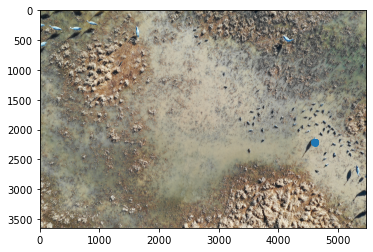

In [20]:
#Visualize one from "test" to see if the correct clusters seem to have been attached
img = "BDA_18A4_20181107_1.JPG"
subset = test[test["filename"] == img]
onecluster = subset.loc[subset["cluster_id"] == 3]

fig, ax = plt.subplots()
img = cv2.imread(imgpath+"/BDA_18A4_20181107_1.JPG")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
ax.imshow(img)
ax.scatter(onecluster["c_x"],onecluster["c_y"])

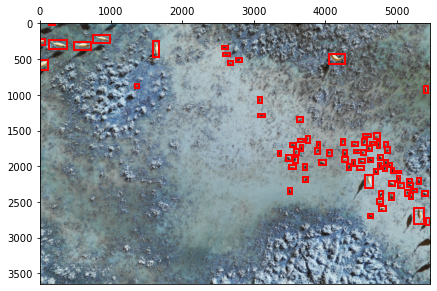

In [38]:
#Checking that refined bounding boxes appear as expected
testimg = "BDA_18A4_20181107_1.JPG"
subset = refined_id[refined_id["filename"] == testimg]
img = cv2.imread(imgpath+"/"+testimg)
#onecluster = subset.loc[subset["cluster_id"] == 0]

bboxes = list(subset["bbox"])

def get_bb(bboxes, img):  
    boxes = bboxes.copy()
    
    return np.squeeze(boxes)

def img_show(img, ax = None, figsize=(7,11)):
  if ax is None: fig, ax = plt.subplots(figsize=figsize)
  ax.xaxis.tick_top()
  ax.imshow(img)  
  return ax

def draw_box(img, ax, bb):
  patch = ax.add_patch(patches.Rectangle((bb[0],bb[1]), bb[2], bb[3], fill=False, edgecolor='red', lw=2))
  
def plot_sample(img,bboxes, ax=None, figsize=(7,11)):
  bb = get_bb(bboxes, img)
  ax = img_show(img, ax=ax)
  for i in range(len(bboxes)):
    draw_box(img,ax,bb[i])

plot_sample(img,bboxes)